In [1]:
!git clone https://github.com/Morzeux/HttpParamsDataset

Cloning into 'HttpParamsDataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [2]:
!pip install optuna

     |████████████████████████████████| 302 kB 7.0 MB/s 
     |████████████████████████████████| 208 kB 48.5 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 111 kB 45.4 MB/s 
     |████████████████████████████████| 141 kB 51.3 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8b207522e2dc3a3a7492169d0cb82cbc3e6bebef15389bf13f84c33fc90c1508
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [4]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [5]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [6]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [7]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))

In [8]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

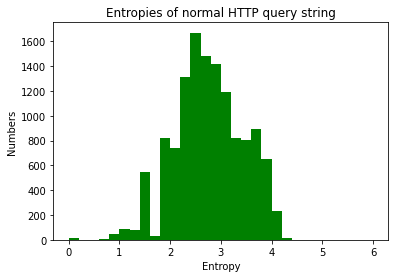

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

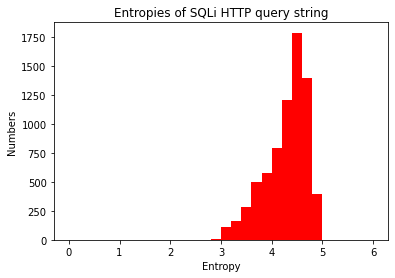

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [11]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


In [12]:
print('{:.2%}'.format(df_sqli['payload'].str.contains('\)').sum() / len(df_sqli['payload'])))

90.91%


In [13]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(df_norm['payload'].str.contains('\)').sum() / len(df_norm['payload'])))

0.01%


In [14]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [15]:
df = func_preprocessing(df)

In [16]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

In [17]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate


class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 64)
        }
        model = DecisionTreeClassifier(**params)
        # 交差検証の設定
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=kf,
                                scoring='neg_log_loss',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_all, y_all)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-09-05 02:15:18,640] A new study created in memory with name: no-name-ac63a1c1-298f-4c1b-a9c8-25f1f0c51b4d
[I 2021-09-05 02:15:19,999] Trial 0 finished with value: -0.2700712879723397 and parameters: {'criterion': 'entropy', 'max_depth': 13}. Best is trial 0 with value: -0.2700712879723397.
[I 2021-09-05 02:15:20,153] Trial 1 finished with value: -0.44513823753416315 and parameters: {'criterion': 'gini', 'max_depth': 31}. Best is trial 1 with value: -0.44513823753416315.
[I 2021-09-05 02:15:20,303] Trial 2 finished with value: -0.4418799489687098 and parameters: {'criterion': 'gini', 'max_depth': 26}. Best is trial 1 with value: -0.44513823753416315.
[I 2021-09-05 02:15:20,444] Trial 3 finished with value: -0.45210777846609984 and parameters: {'criterion': 'gini', 'max_depth': 31}. Best is trial 3 with value: -0.45210777846609984.
[I 2021-09-05 02:15:20,594] Trial 4 finished with value: -0.4361425088231211 and parameters: {'criterion': 'entropy', 'max_depth': 43}. Best is trial 

params: {'criterion': 'gini', 'max_depth': 34}


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

#ハイパーパラメータチューニングで特定した値を設定
params={'criterion': 'gini', 'max_depth': 58}

# 訓練の実施
model = DecisionTreeClassifier(**params)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 98.17639 %
[[3808   39]
 [  71 2114]]


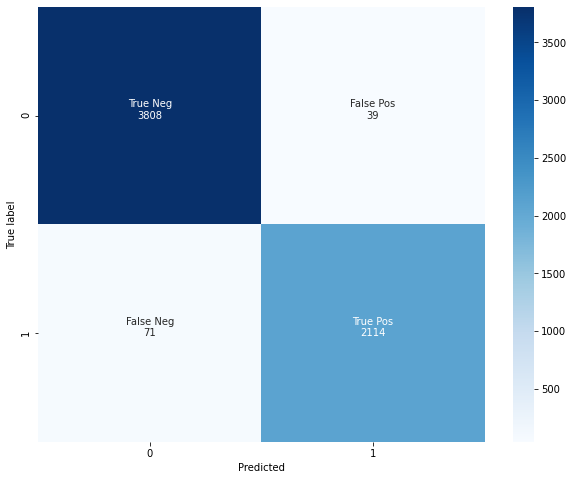

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.show()

In [21]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

In [22]:
X_all

,payload,length,attack_type
0,c/ caridad s/n,14,norm
1,"campello, el",12,norm
2,1442431887503330,16,norm
3,nue37,5,norm
4,tufts3@joll.rs,14,norm
...,...,...,...
10176,"1"") where 2367=2367;select (case when (4666=46...",113,sqli
10177,"1') and updatexml(3393,concat(0x2e,0x7171706a7...",113,sqli
10178,1') as tqdg where 9355=9355;select (case when ...,136,sqli
10179,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,sqli


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

In [24]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names()
np.array(features)

array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype='<U1')

In [25]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

,,"""",',(,),*,",",-,.,0,1,2,3,4,5,6,7,8,9,=,a,b,c,d,e,f,g,h,i,k,l,m,n,o,p,r,s,t,u,v,w,x,y
0,0.453262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367518,0.000000,0.460722,0.504676,0.000000,0.000000,0.000000,0.000000,0.231185,0.000000,0.000000,0.000000,0.213771,0.000000,0.000000,0.209315,0.222629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.223881,0.000000,0.000000,0.000000,0.000000,0.000000,0.297448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181529,0.000000,0.227566,0.000000,0.379535,0.000000,0.000000,0.000000,0.000000,0.000000,0.637700,0.279457,0.000000,0.211999,0.320803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316555,0.257108,0.154605,0.637142,0.493407,0.150187,0.000000,0.165919,0.332115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.488536,0.000000,0.000000,0.000000,0.508881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381555,0.000000,0.000000,0.000000,0.000000,0.000000,0.489108,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382917,0.000000,0.000000,0.000000,0.259419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310430,0.000000,0.000000,0.000000,0.000000,0.407889,0.000000,0.000000,0.203400,0.000000,0.198388,0.422014,0.443910,0.259723,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30151,0.427799,0.061067,0.000000,0.132674,0.162360,0.062953,0.000000,0.096652,0.117327,0.000000,0.064151,0.077151,0.079487,0.164146,0.000000,0.562813,0.082797,0.000000,0.000000,0.086371,0.133412,0.046812,0.100347,0.073281,0.390506,0.047558,0.000000,0.131508,0.000000,0.000000,0.093734,0.082153,0.093121,0.031161,0.000000,0.091180,0.290938,0.170019,0.000000,0.000000,0.100595,0.000000,0.056381
30152,0.166014,0.000000,0.208435,0.267729,0.245725,0.000000,0.264680,0.000000,0.000000,0.159385,0.323633,0.038922,0.360899,0.000000,0.000000,0.121685,0.375929,0.000000,0.129710,0.087146,0.188453,0.000000,0.101248,0.110907,0.140718,0.000000,0.100469,0.000000,0.000000,0.000000,0.094575,0.041445,0.156594,0.031441,0.047577,0.000000,0.032617,0.137235,0.040147,0.000000,0.000000,0.369485,0.000000
30153,0.468956,0.000000,0.049065,0.126046,0.154249,0.059808,0.000000,0.000000,0.055733,0.000000,0.030473,0.183243,0.075516,0.000000,0.142405,0.381927,0.196652,0.000000,0.081423,0.082057,0.152097,0.000000,0.190669,0.069620,0.397499,0.090365,0.047301,0.208231,0.063784,0.000000,0.089051,0.117074,0.147448,0.088813,0.000000,0.144375,0.245693,0.226136,0.000000,0.000000,0.095570,0.000000,0.000000
30154,0.171542,0.000000,0.215375,0.276644,0.253907,0.000000,0.227911,0.000000,0.000000,0.164692,0.234086,0.120653,0.000000,0.000000,0.039068,0.083825,0.517929,0.129590,0.134029,0.090048,0.222546,0.000000,0.174366,0.152800,0.203565,0.000000,0.000000,0.000000,0.000000,0.121721,0.097724,0.000000,0.097085,0.032488,0.000000,0.031687,0.033703,0.177256,0.041484,0.188331,0.000000,0.254525,0.000000


In [26]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, verbose_eval=100, early_stopping_rounds=100, folds=StratifiedKFold(n_splits=5))

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-09-05 02:16:19,981] A new study created in memory with name: no-name-00ecda7e-39c5-49db-b083-0c1b33d1b520
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00162055 + 0.000905295


feature_fraction, val_score: 0.001495:  14%|#4        | 1/7 [00:06<00:36,  6.12s/it]

[100]	cv_agg's binary_logloss: 0.00189494 + 0.00120489


feature_fraction, val_score: 0.001495:  29%|##8       | 2/7 [00:12<00:32,  6.41s/it]

[100]	cv_agg's binary_logloss: 0.00117304 + 0.000764567


feature_fraction, val_score: 0.001152:  43%|####2     | 3/7 [00:17<00:22,  5.60s/it]

[100]	cv_agg's binary_logloss: 0.00235411 + 0.00137145


feature_fraction, val_score: 0.001152:  57%|#####7    | 4/7 [00:24<00:18,  6.06s/it]

[100]	cv_agg's binary_logloss: 0.00301344 + 0.0015852


feature_fraction, val_score: 0.001152:  71%|#######1  | 5/7 [00:31<00:13,  6.56s/it]

[100]	cv_agg's binary_logloss: 0.00115086 + 0.000685716


feature_fraction, val_score: 0.001096:  86%|########5 | 6/7 [00:36<00:06,  6.05s/it]

[100]	cv_agg's binary_logloss: 0.00135099 + 0.000840922


num_leaves, val_score: 0.001096:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00111694 + 0.000725023


num_leaves, val_score: 0.001056:   5%|5         | 1/20 [00:05<01:51,  5.85s/it]

[100]	cv_agg's binary_logloss: 0.00113849 + 0.000728705


num_leaves, val_score: 0.001056:  10%|#         | 2/20 [00:18<02:57,  9.84s/it]

[100]	cv_agg's binary_logloss: 0.00113479 + 0.000731405


num_leaves, val_score: 0.001056:  15%|#5        | 3/20 [00:32<03:17, 11.62s/it]

[100]	cv_agg's binary_logloss: 0.00114706 + 0.000731089


num_leaves, val_score: 0.001056:  20%|##        | 4/20 [00:46<03:24, 12.77s/it]

[100]	cv_agg's binary_logloss: 0.00154185 + 0.000722785
[200]	cv_agg's binary_logloss: 0.00167612 + 0.00129868


num_leaves, val_score: 0.001056:  25%|##5       | 5/20 [00:50<02:24,  9.62s/it]

[100]	cv_agg's binary_logloss: 0.00112603 + 0.000722668


num_leaves, val_score: 0.001056:  30%|###       | 6/20 [01:00<02:17,  9.81s/it]

[100]	cv_agg's binary_logloss: 0.00113694 + 0.000731555


num_leaves, val_score: 0.001056:  35%|###5      | 7/20 [01:14<02:24, 11.11s/it]

[100]	cv_agg's binary_logloss: 0.00115196 + 0.000720322


num_leaves, val_score: 0.001056:  40%|####      | 8/20 [01:24<02:06, 10.56s/it]

[100]	cv_agg's binary_logloss: 0.00114495 + 0.000725133


num_leaves, val_score: 0.001056:  45%|####5     | 9/20 [01:39<02:12, 12.08s/it]

[100]	cv_agg's binary_logloss: 0.00114793 + 0.00072406


num_leaves, val_score: 0.001056:  50%|#####     | 10/20 [01:54<02:10, 13.03s/it]

[100]	cv_agg's binary_logloss: 0.00136113 + 0.00068317


num_leaves, val_score: 0.001056:  55%|#####5    | 11/20 [01:58<01:32, 10.28s/it]

[100]	cv_agg's binary_logloss: 0.0011411 + 0.000725945


num_leaves, val_score: 0.001056:  60%|######    | 12/20 [02:07<01:18,  9.77s/it]

[100]	cv_agg's binary_logloss: 0.00110957 + 0.000758716


num_leaves, val_score: 0.001047:  65%|######5   | 13/20 [02:13<01:01,  8.80s/it]

[100]	cv_agg's binary_logloss: 0.00112153 + 0.000726107


num_leaves, val_score: 0.001047:  70%|#######   | 14/20 [02:20<00:48,  8.12s/it]

[100]	cv_agg's binary_logloss: 0.00114237 + 0.000714988


num_leaves, val_score: 0.001047:  75%|#######5  | 15/20 [02:27<00:38,  7.72s/it]

[100]	cv_agg's binary_logloss: 0.00114237 + 0.000714988


num_leaves, val_score: 0.001047:  80%|########  | 16/20 [02:34<00:29,  7.43s/it]

[100]	cv_agg's binary_logloss: 0.0011498 + 0.000680302


num_leaves, val_score: 0.001047:  85%|########5 | 17/20 [02:39<00:20,  6.76s/it]

[100]	cv_agg's binary_logloss: 0.00113452 + 0.000711621


num_leaves, val_score: 0.001047:  90%|######### | 18/20 [02:50<00:16,  8.16s/it]

[100]	cv_agg's binary_logloss: 0.00113882 + 0.000718365


num_leaves, val_score: 0.001047:  95%|#########5| 19/20 [02:58<00:08,  8.19s/it]

[100]	cv_agg's binary_logloss: 0.00113474 + 0.000711582


bagging, val_score: 0.001047:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00127629 + 0.000733487


bagging, val_score: 0.001047:  10%|#         | 1/10 [00:06<01:00,  6.75s/it]

[100]	cv_agg's binary_logloss: 0.00116642 + 0.000828052


bagging, val_score: 0.001047:  20%|##        | 2/10 [00:13<00:55,  6.98s/it]

[200]	cv_agg's binary_logloss: 0.00141007 + 0.0013771
[100]	cv_agg's binary_logloss: 0.00119834 + 0.000770547


bagging, val_score: 0.001047:  30%|###       | 3/10 [00:21<00:50,  7.23s/it]

[100]	cv_agg's binary_logloss: 0.00127792 + 0.000880408


bagging, val_score: 0.001047:  40%|####      | 4/10 [00:28<00:43,  7.27s/it]

[100]	cv_agg's binary_logloss: 0.00126651 + 0.000864702


bagging, val_score: 0.001047:  50%|#####     | 5/10 [00:35<00:35,  7.17s/it]

[100]	cv_agg's binary_logloss: 0.00120658 + 0.000842434


bagging, val_score: 0.001047:  60%|######    | 6/10 [00:43<00:28,  7.20s/it]

[100]	cv_agg's binary_logloss: 0.00117285 + 0.000675238


bagging, val_score: 0.001047:  70%|#######   | 7/10 [00:51<00:22,  7.54s/it]

[100]	cv_agg's binary_logloss: 0.00114383 + 0.000828995


bagging, val_score: 0.001047:  80%|########  | 8/10 [00:58<00:15,  7.58s/it]

[100]	cv_agg's binary_logloss: 0.00115127 + 0.000792395


bagging, val_score: 0.001047:  90%|######### | 9/10 [01:06<00:07,  7.49s/it]

[100]	cv_agg's binary_logloss: 0.00122435 + 0.000728717


feature_fraction_stage2, val_score: 0.001047:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00118392 + 0.000659149


feature_fraction_stage2, val_score: 0.001047:  17%|#6        | 1/6 [00:06<00:31,  6.22s/it]

[100]	cv_agg's binary_logloss: 0.00122662 + 0.000760058


feature_fraction_stage2, val_score: 0.001047:  33%|###3      | 2/6 [00:13<00:26,  6.64s/it]

[100]	cv_agg's binary_logloss: 0.00110911 + 0.000675958


feature_fraction_stage2, val_score: 0.001047:  50%|#####     | 3/6 [00:19<00:19,  6.51s/it]

[100]	cv_agg's binary_logloss: 0.00115128 + 0.000728289


feature_fraction_stage2, val_score: 0.001047:  67%|######6   | 4/6 [00:26<00:13,  6.62s/it]

[100]	cv_agg's binary_logloss: 0.00121271 + 0.000728198


feature_fraction_stage2, val_score: 0.001047:  83%|########3 | 5/6 [00:33<00:06,  6.80s/it]

[100]	cv_agg's binary_logloss: 0.00111769 + 0.000791942


regularization_factors, val_score: 0.001047:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0012456 + 0.000710717


regularization_factors, val_score: 0.001047:   5%|5         | 1/20 [00:04<01:28,  4.65s/it]

[100]	cv_agg's binary_logloss: 0.00138536 + 0.000598409
[200]	cv_agg's binary_logloss: 0.00145663 + 0.00076582


regularization_factors, val_score: 0.001047:  10%|#         | 2/20 [00:09<01:24,  4.67s/it]

[100]	cv_agg's binary_logloss: 0.00175439 + 0.000528578
[200]	cv_agg's binary_logloss: 0.00149181 + 0.000680562
[300]	cv_agg's binary_logloss: 0.00148234 + 0.000760936


regularization_factors, val_score: 0.001047:  15%|#5        | 3/20 [00:17<01:43,  6.12s/it]

[100]	cv_agg's binary_logloss: 0.00126803 + 0.000660557


regularization_factors, val_score: 0.001047:  20%|##        | 4/20 [00:21<01:24,  5.29s/it]

[100]	cv_agg's binary_logloss: 0.00230736 + 0.000477128
[200]	cv_agg's binary_logloss: 0.00221091 + 0.000488332
[300]	cv_agg's binary_logloss: 0.00221091 + 0.000488328
[400]	cv_agg's binary_logloss: 0.00221091 + 0.000488328
[500]	cv_agg's binary_logloss: 0.00221091 + 0.000488328


regularization_factors, val_score: 0.001047:  25%|##5       | 5/20 [00:26<01:21,  5.43s/it]

[600]	cv_agg's binary_logloss: 0.00221091 + 0.000488328
[100]	cv_agg's binary_logloss: 0.00109961 + 0.000749484


regularization_factors, val_score: 0.001044:  30%|###       | 6/20 [00:32<01:15,  5.41s/it]

[100]	cv_agg's binary_logloss: 0.00108781 + 0.000761148


regularization_factors, val_score: 0.001035:  35%|###5      | 7/20 [00:37<01:10,  5.42s/it]

[100]	cv_agg's binary_logloss: 0.00154128 + 0.000626364
[200]	cv_agg's binary_logloss: 0.00144309 + 0.000762098


regularization_factors, val_score: 0.001035:  40%|####      | 8/20 [00:43<01:04,  5.40s/it]

[100]	cv_agg's binary_logloss: 0.0011086 + 0.000747301


regularization_factors, val_score: 0.001035:  45%|####5     | 9/20 [00:48<00:59,  5.40s/it]

[100]	cv_agg's binary_logloss: 0.0012808 + 0.000647281


regularization_factors, val_score: 0.001035:  50%|#####     | 10/20 [00:52<00:49,  4.92s/it]

[100]	cv_agg's binary_logloss: 0.00122016 + 0.000728799


regularization_factors, val_score: 0.001035:  55%|#####5    | 11/20 [00:56<00:43,  4.84s/it]

[100]	cv_agg's binary_logloss: 0.00108226 + 0.000731865


regularization_factors, val_score: 0.001023:  60%|######    | 12/20 [01:02<00:39,  4.98s/it]

[100]	cv_agg's binary_logloss: 0.00108685 + 0.00073035


regularization_factors, val_score: 0.001023:  65%|######5   | 13/20 [01:07<00:36,  5.19s/it]

[100]	cv_agg's binary_logloss: 0.0011175 + 0.000706019


regularization_factors, val_score: 0.001023:  70%|#######   | 14/20 [01:13<00:30,  5.16s/it]

[100]	cv_agg's binary_logloss: 0.00110056 + 0.000727463


regularization_factors, val_score: 0.001023:  75%|#######5  | 15/20 [01:18<00:26,  5.30s/it]

[100]	cv_agg's binary_logloss: 0.00153131 + 0.000660239
[200]	cv_agg's binary_logloss: 0.00148396 + 0.00068083


regularization_factors, val_score: 0.001023:  80%|########  | 16/20 [01:22<00:18,  4.75s/it]

[100]	cv_agg's binary_logloss: 0.00115363 + 0.000724189


regularization_factors, val_score: 0.001023:  85%|########5 | 17/20 [01:26<00:14,  4.76s/it]

[100]	cv_agg's binary_logloss: 0.00109121 + 0.000742601


regularization_factors, val_score: 0.001023:  90%|######### | 18/20 [01:32<00:10,  5.10s/it]

[100]	cv_agg's binary_logloss: 0.00124236 + 0.00068304


regularization_factors, val_score: 0.001023:  95%|#########5| 19/20 [01:36<00:04,  4.82s/it]

[100]	cv_agg's binary_logloss: 0.00112856 + 0.000731215


min_data_in_leaf, val_score: 0.001023:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00110313 + 0.00074599


min_data_in_leaf, val_score: 0.001023:  20%|##        | 1/5 [00:05<00:21,  5.40s/it]

[100]	cv_agg's binary_logloss: 0.00122185 + 0.000801881


min_data_in_leaf, val_score: 0.001023:  40%|####      | 2/5 [00:10<00:15,  5.30s/it]

[100]	cv_agg's binary_logloss: 0.00111833 + 0.000765589


min_data_in_leaf, val_score: 0.001023:  60%|######    | 3/5 [00:16<00:10,  5.36s/it]

[100]	cv_agg's binary_logloss: 0.00115634 + 0.000692133


min_data_in_leaf, val_score: 0.001023:  80%|########  | 4/5 [00:21<00:05,  5.34s/it]

[100]	cv_agg's binary_logloss: 0.00130964 + 0.000784104


min_data_in_leaf, val_score: 0.001023: 100%|##########| 5/5 [00:26<00:00,  5.33s/it]

[200]	cv_agg's binary_logloss: 0.00154479 + 0.00142915


In [27]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9989774890507375
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.00010270105284886144, 'lambda_l2': 2.659170653268176e-06, 'num_leaves': 55, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.00010270105284886144
    lambda_l2: 2.659170653268176e-06
    num_leaves: 55
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定(このパラメータは参考値)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels_lgb = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels_lgb)))
print(confusion_matrix(y_test, pred_labels_lgb))

Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]


# 以下が７章の課題のコード

In [29]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    # 探索対象のハイパーパラメータを設定
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr = xgb.XGBRegressor(
        eta = eta,
        gamma = gamma,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        max_delta_step = max_delta_step,
        subsample = subsample,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha
        )

    regr.fit(X_train, y_train)

    pred = regr.predict(X_test)
    pred_labels = np.rint(preds)

    accuracy = accuracy_score(y_test, pred_labels)
    return (1-accuracy)

study = optuna.create_study()
study.optimize(objective, n_trials=30)
# ベストのパラメーターの出力
print('Best params:', study.best_params)

[I 2021-09-05 02:24:15,015] A new study created in memory with name: no-name-271911a6-5b48-42e1-8743-5493ab670798


[02:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:24,044] Trial 0 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.6254601994626195, 'gamma': 0.17852373514296782, 'max_depth': 18, 'min_child_weight': 1.3382860381713454e-08, 'max_delta_step': 9.834100248079152e-07, 'subsample': 0.7517767996063593, 'reg_lambda': 33.277329926182155, 'reg_alpha': 995.745775125432}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:29,611] Trial 1 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0002869835303074136, 'gamma': 0.23665910447982924, 'max_depth': 13, 'min_child_weight': 4.9337257660030465e-08, 'max_delta_step': 0.0006004416303772196, 'subsample': 0.3243954627316239, 'reg_lambda': 925.4166334904593, 'reg_alpha': 472.44626836565163}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:31,898] Trial 2 finished with value: 0.0003315649867373649 and parameters: {'eta': 2.0117787056404907e-05, 'gamma': 1.4088696078373436e-07, 'max_depth': 3, 'min_child_weight': 0.9186776721815576, 'max_delta_step': 3.1691600925416887e-06, 'subsample': 0.15038834066508655, 'reg_lambda': 119.11648774905348, 'reg_alpha': 327.96045991809507}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:37,665] Trial 3 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0557736280271786, 'gamma': 2.980812245371195e-07, 'max_depth': 10, 'min_child_weight': 1.4784551728761404e-07, 'max_delta_step': 5.337724378025451e-08, 'subsample': 0.6080034546161297, 'reg_lambda': 972.7305934345187, 'reg_alpha': 731.957941638958}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:46,220] Trial 4 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.6169853670108905, 'gamma': 0.42067732886370063, 'max_depth': 20, 'min_child_weight': 0.07083408738850203, 'max_delta_step': 0.00048030903406283615, 'subsample': 0.6586910740352485, 'reg_lambda': 546.07365632378, 'reg_alpha': 931.6278951835635}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:49,844] Trial 5 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.7367545079965238e-06, 'gamma': 6.096881726931849e-06, 'max_depth': 18, 'min_child_weight': 1.1818607908018775e-08, 'max_delta_step': 7.583692840321158e-08, 'subsample': 0.2895886873073912, 'reg_lambda': 830.5491826528961, 'reg_alpha': 934.3799326386905}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:59,070] Trial 6 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.5116247571484296e-05, 'gamma': 5.7262815194303864e-08, 'max_depth': 16, 'min_child_weight': 1.0822980478037388e-07, 'max_delta_step': 0.021685614328101854, 'subsample': 0.7884323382917234, 'reg_lambda': 684.9754862230978, 'reg_alpha': 809.1832047330396}. Best is trial 0 with value: 0.0003315649867373649.


[02:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:24:59,883] Trial 7 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.001534901720434476, 'gamma': 0.002202101420489138, 'max_depth': 2, 'min_child_weight': 1.7016941715584855e-07, 'max_delta_step': 0.10960777014395194, 'subsample': 0.004261978441958636, 'reg_lambda': 98.93028929969871, 'reg_alpha': 723.6946422275419}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:07,592] Trial 8 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.1832063136689695e-06, 'gamma': 8.325588236169554e-05, 'max_depth': 10, 'min_child_weight': 1.756384832893889e-08, 'max_delta_step': 1.2463886015582876e-07, 'subsample': 0.7132669233978217, 'reg_lambda': 141.9419556493755, 'reg_alpha': 32.63146023241858}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:16,230] Trial 9 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.004439162305292071, 'gamma': 0.001257655989666605, 'max_depth': 12, 'min_child_weight': 1.2824904151775574e-08, 'max_delta_step': 1.2599600810593324e-05, 'subsample': 0.6420674690058396, 'reg_lambda': 692.5989940393958, 'reg_alpha': 138.52427766922682}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:25,196] Trial 10 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.627233573575142e-08, 'gamma': 0.017019854473660008, 'max_depth': 6, 'min_child_weight': 5.827342781000754e-05, 'max_delta_step': 2.5783603426980107e-06, 'subsample': 0.9783694722509266, 'reg_lambda': 324.94797580973386, 'reg_alpha': 545.0324181579175}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:31,666] Trial 11 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0007532632396209216, 'gamma': 0.9572254302007261, 'max_depth': 14, 'min_child_weight': 7.549757979487367e-06, 'max_delta_step': 0.0008422056147723048, 'subsample': 0.3992993302159183, 'reg_lambda': 362.11240812044025, 'reg_alpha': 432.7996341346941}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:38,563] Trial 12 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.660124810324766, 'gamma': 0.06418469520713076, 'max_depth': 16, 'min_child_weight': 2.1437282685977405e-06, 'max_delta_step': 0.004766676123855449, 'subsample': 0.4489442049778087, 'reg_lambda': 989.3119412298543, 'reg_alpha': 577.5658574902659}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:48,774] Trial 13 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.3149852511139506e-08, 'gamma': 0.022774461960314747, 'max_depth': 20, 'min_child_weight': 0.0075869413370127205, 'max_delta_step': 5.880132042951886e-05, 'subsample': 0.9010242654656025, 'reg_lambda': 349.00066530149263, 'reg_alpha': 319.9867487358006}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:51,907] Trial 14 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.008617275339396466, 'gamma': 0.0004976481915684954, 'max_depth': 13, 'min_child_weight': 0.0005403012480805104, 'max_delta_step': 0.9651033658615316, 'subsample': 0.26655099830075496, 'reg_lambda': 610.1199764528047, 'reg_alpha': 621.4466697539584}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:25:59,666] Trial 15 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0001255138447772902, 'gamma': 0.1053630430358211, 'max_depth': 8, 'min_child_weight': 2.886501073425556e-06, 'max_delta_step': 1.3857363164386847e-06, 'subsample': 0.55272108333298, 'reg_lambda': 817.0300105631037, 'reg_alpha': 362.33847370709987}. Best is trial 0 with value: 0.0003315649867373649.


[02:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:06,086] Trial 16 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.05833539809365679, 'gamma': 1.887561034470614e-05, 'max_depth': 16, 'min_child_weight': 4.951467201275689e-07, 'max_delta_step': 1.024388720390248e-08, 'subsample': 0.8120664155000572, 'reg_lambda': 2.383958619441433, 'reg_alpha': 235.68091839085864}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:08,455] Trial 17 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.02634087002145467, 'gamma': 0.0015056756798649637, 'max_depth': 18, 'min_child_weight': 0.0006381294258392863, 'max_delta_step': 0.641950059401799, 'subsample': 0.16829116337832445, 'reg_lambda': 508.52045583336303, 'reg_alpha': 626.5114216489461}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:15,546] Trial 18 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.4927027344144223e-07, 'gamma': 0.010773999773243243, 'max_depth': 7, 'min_child_weight': 2.3497361698769838e-05, 'max_delta_step': 5.598058889144908e-07, 'subsample': 0.5231364220989371, 'reg_lambda': 796.0128956631872, 'reg_alpha': 369.42534936434015}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:22,006] Trial 19 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.11677657013210094, 'gamma': 9.829362297163074e-06, 'max_depth': 16, 'min_child_weight': 6.600130876759066e-07, 'max_delta_step': 1.5421765427298114e-08, 'subsample': 0.8176332161265111, 'reg_lambda': 22.332715648644523, 'reg_alpha': 143.95240163722013}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:23,134] Trial 20 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.01509807210829133, 'gamma': 0.000258553278315504, 'max_depth': 18, 'min_child_weight': 0.0006163193797483417, 'max_delta_step': 5.066598742058845e-05, 'subsample': 0.11589705910660347, 'reg_lambda': 241.57398976523, 'reg_alpha': 968.852561980606}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:28,890] Trial 21 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.0227626442162523e-07, 'gamma': 0.006077784149847087, 'max_depth': 5, 'min_child_weight': 3.9841579351152366e-05, 'max_delta_step': 6.212970903421262e-07, 'subsample': 0.507442601196183, 'reg_lambda': 456.25832076715267, 'reg_alpha': 839.1141675429697}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:35,286] Trial 22 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.194434696686752, 'gamma': 1.4954998328969898e-05, 'max_depth': 8, 'min_child_weight': 9.46664411722168e-07, 'max_delta_step': 1.75619447068294e-08, 'subsample': 0.7945253893762848, 'reg_lambda': 3.9072829393046185, 'reg_alpha': 142.66150022927872}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:45,564] Trial 23 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.1750591336474194, 'gamma': 2.053305175360853e-06, 'max_depth': 18, 'min_child_weight': 0.0010842765240246545, 'max_delta_step': 2.842572604576074e-05, 'subsample': 0.9008610892335595, 'reg_lambda': 230.99168655090128, 'reg_alpha': 996.0570384861294}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:46,595] Trial 24 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.008571596425965687, 'gamma': 0.00016929912224411425, 'max_depth': 4, 'min_child_weight': 0.007750319976977726, 'max_delta_step': 8.997085644573766e-06, 'subsample': 0.08083843651996914, 'reg_lambda': 430.770712391655, 'reg_alpha': 832.4207748702947}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:26:53,553] Trial 25 finished with value: 0.0003315649867373649 and parameters: {'eta': 4.145249222784933e-07, 'gamma': 1.2194096509615633e-08, 'max_depth': 5, 'min_child_weight': 1.058245185802082e-05, 'max_delta_step': 4.1604524279255906e-07, 'subsample': 0.7324619523086839, 'reg_lambda': 230.0226586476608, 'reg_alpha': 852.4746185084477}. Best is trial 0 with value: 0.0003315649867373649.


[02:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:27:04,646] Trial 26 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.32592781972094415, 'gamma': 1.3402159783592909e-06, 'max_depth': 9, 'min_child_weight': 0.006501267789484357, 'max_delta_step': 1.1274132220988153e-05, 'subsample': 0.9996637108617457, 'reg_lambda': 196.3892576777021, 'reg_alpha': 716.1639845409702}. Best is trial 0 with value: 0.0003315649867373649.


[02:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:27:07,289] Trial 27 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.002847133547981153, 'gamma': 1.2966823861476087e-06, 'max_depth': 1, 'min_child_weight': 0.0072642120867254575, 'max_delta_step': 2.494160273381861e-05, 'subsample': 0.8889245717540482, 'reg_lambda': 294.93546268901355, 'reg_alpha': 884.4658932044184}. Best is trial 0 with value: 0.0003315649867373649.


[02:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:27:13,350] Trial 28 finished with value: 0.0003315649867373649 and parameters: {'eta': 7.227234259858652e-07, 'gamma': 1.000426761561176e-08, 'max_depth': 4, 'min_child_weight': 0.04110806426222303, 'max_delta_step': 2.6077108839542823e-07, 'subsample': 0.7124866887391038, 'reg_lambda': 92.35818564094157, 'reg_alpha': 800.5563177862155}. Best is trial 0 with value: 0.0003315649867373649.


[02:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-09-05 02:27:24,308] Trial 29 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0002966535759599746, 'gamma': 2.5582196297604864e-08, 'max_depth': 9, 'min_child_weight': 0.00014004153975288376, 'max_delta_step': 0.00013921744466840745, 'subsample': 0.9842738088028713, 'reg_lambda': 185.4439520200757, 'reg_alpha': 749.1480853804251}. Best is trial 0 with value: 0.0003315649867373649.


Best params: {'eta': 0.6254601994626195, 'gamma': 0.17852373514296782, 'max_depth': 18, 'min_child_weight': 1.3382860381713454e-08, 'max_delta_step': 9.834100248079152e-07, 'subsample': 0.7517767996063593, 'reg_lambda': 33.277329926182155, 'reg_alpha': 995.745775125432}


In [30]:
optimised_model = xgb.XGBRegressor(eta = study.best_params['eta'],gamma = study.best_params['gamma'],
                                max_depth = study.best_params['max_depth'],min_child_weight = study.best_params['min_child_weight'],
                                max_delta_step = study.best_params['max_delta_step'],subsample = study.best_params['subsample'],
                                reg_lambda = study.best_params['reg_lambda'],reg_alpha = study.best_params['reg_alpha'])

optimised_model.fit(X_train, y_train)

# テスト用データを使って予測する
pred_labels_xgb = optimised_model.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels_xgb_round = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels_xgb_round)))
print(confusion_matrix(y_test, pred_labels_xgb_round))

[02:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]


In [31]:
preds_ans = pred_labels_lgb * 0.5 + pred_labels_xgb * 0.5

In [32]:
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, np.rint(preds_ans))))
print(confusion_matrix(y_test, np.rint(preds_ans)))

Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]
